Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [2]:
passengers = np.array(df['Passengers'], dtype=np.float32)
print(passengers)
print(passengers.dtype)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]
float32


Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [3]:
train_size = int(len(passengers) * 0.67)

train_data = passengers[:train_size]
val_data = passengers[train_size:]

print("Train data:", train_data)
print("Validation data:", val_data)

Train data: [112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306.]
Validation data: [315. 301. 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318.
 362. 348. 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396.
 420. 472. 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535.
 622. 606. 508. 461. 390. 432.]


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [4]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        window = dataset[i:i + lookback]
        target = dataset[i + lookback]
        
        X.append(window)
        y.append(target)

    X = torch.tensor(np.array(X), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.float32)

    if lookback == 1:
        X = X.squeeze(1)   
        X = X.unsqueeze(1) 

    return X, y

In [5]:
lookback = 1
X_train, y_train = create_dataset(train_data, lookback=lookback)
X_val, y_val = create_dataset(val_data, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([95, 1]) torch.Size([95])
torch.Size([47, 1]) torch.Size([47])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [6]:
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(AirModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        if x.dim() == 2:  
            x = x.unsqueeze(1)

        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        out = self.fc(out)
        return out


In [7]:
model = AirModel(hidden_size=50, num_layers=1)

In [8]:
x = torch.tensor([[112.]], dtype=torch.float32).unsqueeze(0)  # → (1,1,1)
print("Input shape:", x.shape)

y_pred = model(x)
print("Output:", y_pred)
print("Output shape:", y_pred.shape)

Input shape: torch.Size([1, 1, 1])
Output: tensor([[-0.0946]], grad_fn=<AddmmBackward0>)
Output shape: torch.Size([1, 1])


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [9]:
train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,     
    shuffle=True      
)

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

EPOCHS = 2000

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    batch_count = 0

    # -------- ТРЕНУВАННЯ --------
    for batch_X, batch_y in train_loader:
        batch_y = batch_y.unsqueeze(1)  
        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    losses.append(avg_loss)

    # -------- ВАЛІДАЦІЯ КОЖНІ 100 ЕПОХ --------
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            # TRAIN RMSE
            train_preds = model(X_train)
            train_mse = criterion(train_preds, y_train.unsqueeze(1))
            train_rmse = torch.sqrt(train_mse).item()

            # VAL RMSE
            val_preds = model(X_val)
            val_mse = criterion(val_preds, y_val.unsqueeze(1))
            val_rmse = torch.sqrt(val_mse).item()

        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {val_rmse:.4f}")


Epoch 0: train RMSE 23.5540, test RMSE 101.9610
Epoch 100: train RMSE 24.0453, test RMSE 99.9595
Epoch 200: train RMSE 24.6317, test RMSE 97.2953
Epoch 300: train RMSE 24.3085, test RMSE 98.1001
Epoch 400: train RMSE 23.2229, test RMSE 95.9021
Epoch 500: train RMSE 23.4446, test RMSE 94.7617
Epoch 600: train RMSE 23.0940, test RMSE 94.1999
Epoch 700: train RMSE 23.4834, test RMSE 94.4187
Epoch 800: train RMSE 23.0095, test RMSE 92.2421
Epoch 900: train RMSE 23.8595, test RMSE 90.2389
Epoch 1000: train RMSE 22.9966, test RMSE 89.8944
Epoch 1100: train RMSE 22.8856, test RMSE 89.7975
Epoch 1200: train RMSE 23.1490, test RMSE 91.5125
Epoch 1300: train RMSE 22.9236, test RMSE 88.4462
Epoch 1400: train RMSE 22.8699, test RMSE 88.7543
Epoch 1500: train RMSE 23.2706, test RMSE 90.9010
Epoch 1600: train RMSE 23.1448, test RMSE 87.1131
Epoch 1700: train RMSE 24.5535, test RMSE 88.1750
Epoch 1800: train RMSE 23.0330, test RMSE 85.8359
Epoch 1900: train RMSE 22.8621, test RMSE 86.2572


**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

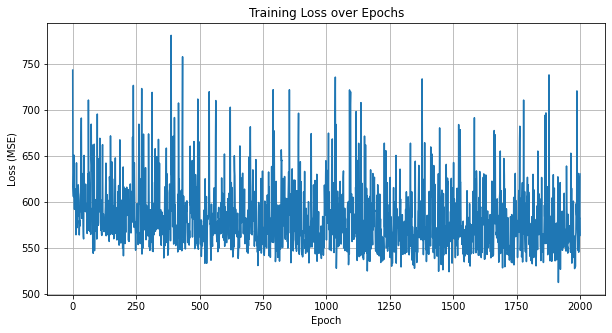

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()

Loss падає — але дуже повільно

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

In [16]:
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

NameError: name 'timeseries' is not defined

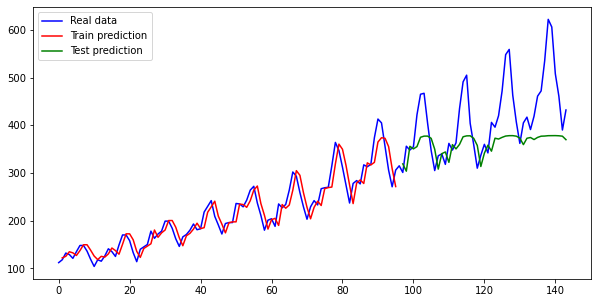

In [20]:
def plot_predicts():
    series = passengers 

    train_plot = np.full_like(series, np.nan, dtype=float)
    test_plot = np.full_like(series, np.nan, dtype=float)

    with torch.no_grad():
        # Прогнози для тренувальних
        train_pred = model(X_train).squeeze().numpy()
        train_plot[lookback:train_size] = train_pred

        # Прогнози для тестових
        test_pred = model(X_val).squeeze().numpy()
        test_plot[train_size+lookback:] = test_pred

    # Візуалізація
    plt.figure(figsize=(10, 5))
    plt.plot(series, label="Real data", c="b")
    plt.plot(train_plot, label="Train prediction", c="r")
    plt.plot(test_plot, label="Test prediction", c="g")
    plt.legend()
    plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [21]:
model_h100 = AirModel(hidden_size=100, num_layers=1)

In [22]:
criterion = nn.MSELoss()
optimizer_h100 = torch.optim.Adam(model_h100.parameters(), lr=0.001)

losses_h100 = []
EPOCHS = 2000


In [23]:
for epoch in range(EPOCHS):
    model_h100.train()
    epoch_loss = 0
    batch_count = 0

    for batch_X, batch_y in train_loader:
        batch_y = batch_y.unsqueeze(1)  # ВАЖЛИВО!

        optimizer_h100.zero_grad()

        preds = model_h100(batch_X)
        loss = criterion(preds, batch_y)

        loss.backward()
        optimizer_h100.step()

        epoch_loss += loss.item()
        batch_count += 1

    losses_h100.append(epoch_loss / batch_count)

    # ---- Валідація ----
    if epoch % 100 == 0:
        model_h100.eval()
        with torch.no_grad():

            # TRAIN
            train_preds = model_h100(X_train)
            train_mse = criterion(train_preds, y_train.unsqueeze(1))
            train_rmse = torch.sqrt(train_mse).item()

            # TEST
            val_preds = model_h100(X_val)
            val_mse = criterion(val_preds, y_val.unsqueeze(1))
            val_rmse = torch.sqrt(val_mse).item()

        print(f"[h100] Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {val_rmse:.4f}")


[h100] Epoch 0: train RMSE 225.7305, test RMSE 422.0945
[h100] Epoch 100: train RMSE 149.5873, test RMSE 341.2119
[h100] Epoch 200: train RMSE 100.7179, test RMSE 282.8092
[h100] Epoch 300: train RMSE 71.0508, test RMSE 238.7427
[h100] Epoch 400: train RMSE 51.3056, test RMSE 201.9149
[h100] Epoch 500: train RMSE 38.5964, test RMSE 172.4470
[h100] Epoch 600: train RMSE 31.0171, test RMSE 149.3934
[h100] Epoch 700: train RMSE 27.2085, test RMSE 132.2912
[h100] Epoch 800: train RMSE 26.3968, test RMSE 118.8926
[h100] Epoch 900: train RMSE 24.5130, test RMSE 110.5084
[h100] Epoch 1000: train RMSE 23.7113, test RMSE 104.3838
[h100] Epoch 1100: train RMSE 25.4876, test RMSE 100.7678
[h100] Epoch 1200: train RMSE 23.3014, test RMSE 96.7404
[h100] Epoch 1300: train RMSE 23.5720, test RMSE 96.2201
[h100] Epoch 1400: train RMSE 23.0644, test RMSE 92.4671
[h100] Epoch 1500: train RMSE 25.1897, test RMSE 93.0632
[h100] Epoch 1600: train RMSE 24.8224, test RMSE 87.8771
[h100] Epoch 1700: train RMS

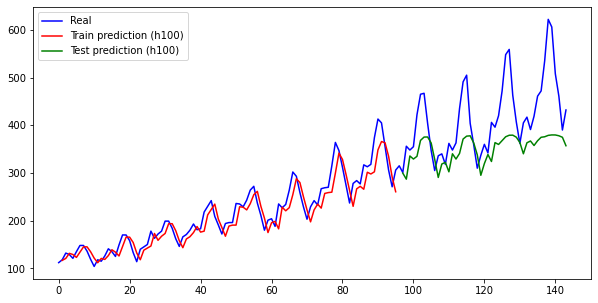

In [24]:
def plot_predicts_h100():
    series = passengers

    train_plot = np.full_like(series, np.nan, dtype=float)
    test_plot = np.full_like(series, np.nan, dtype=float)

    with torch.no_grad():
        train_pred = model_h100(X_train).squeeze().numpy()
        test_pred = model_h100(X_val).squeeze().numpy()

    train_plot[lookback:train_size] = train_pred
    test_plot[train_size+lookback:] = test_pred

    plt.figure(figsize=(10,5))
    plt.plot(series, label="Real", c="b")
    plt.plot(train_plot, label="Train prediction (h100)", c="r")
    plt.plot(test_plot, label="Test prediction (h100)", c="g")
    plt.legend()
    plt.show()

plot_predicts_h100()
